In [ ]:
import pandas as pd

In [ ]:

data=pd.read_csv("../dataset/total_state_data.csv")

In [ ]:
data.columns

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class RowToState:
    def __init__(self, row):
        self.goal_center = np.array([120, 40])
        self.goal_left = np.array([120, 44])
        self.goal_right = np.array([120, 36])
        self.row = row
        self.actor_x = row['actor_x']
        self.actor_y = row['actor_y']
        self.feature_stack = []
        self.outcome_name = ['nan', 'Incomplete', 'Out', 'Unknown', 'Pass Offside', 'success']
        self.enc = OneHotEncoder(sparse_output=False)
        self.enc.fit(np.array(self.outcome_name).reshape(-1, 1))

    def visualize(self):
        num_features = len(self.feature_stack)
        num_cols = 3
        num_rows = (num_features + num_cols - 1) // num_cols

        plt.figure(figsize=(15, 5 * num_rows))
        for i, feature in enumerate(self.feature_stack):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(feature, cmap='viridis', interpolation='nearest')
            plt.colorbar()
            plt.title(f'Feature {i + 1}')
        plt.tight_layout()
        plt.show()

    def calculate_distance(self, x, y, target_x, target_y):
        return np.sqrt((x - target_x)**2 + (y - target_y)**2)

    def distance(self, desde):
        create_array = np.zeros((80, 120), dtype=float)
        for y in range(create_array.shape[0]):
            for x in range(create_array.shape[1]):
                if desde == "ball":
                    dist = self.calculate_distance(x, y, self.actor_x, self.actor_y)
                elif desde == "goal":
                    dist = self.calculate_distance(x, y, self.goal_center[0], self.goal_center[1])
                create_array[y, x] = dist
        self.feature_stack.append(create_array)
        return self

    def angle(self, focus, que):
        create_array = np.zeros((80, 120), dtype=float)

        # 각도 계산 및 저장
        for y in range(create_array.shape[0]):
            for x in range(create_array.shape[1]):
                my_position = np.array([x, y])

                if focus == "goalpost":
                    # 벡터 계산
                    upper_vector = self.goal_left - my_position
                    lower_vector = self.goal_right - my_position
                elif focus == "ball":
                    ball_position = np.array([self.row['actor_x'], self.row['actor_y']])
                    # 벡터 계산
                    upper_vector = ball_position - my_position
                    lower_vector = self.goal_center - my_position

                # 벡터 크기 계산
                upper_norm = np.linalg.norm(upper_vector)
                lower_norm = np.linalg.norm(lower_vector)

                # 코사인 값 계산
                if upper_norm != 0 and lower_norm != 0:
                    if que == "cosine":
                        tri_func = np.dot(upper_vector, lower_vector) / (upper_norm * lower_norm)
                    elif que == "angle":
                        cos_angle = np.dot(upper_vector, lower_vector) / (upper_norm * lower_norm)
                        tri_func = np.arccos(np.clip(cos_angle, -1.0, 1.0))
                    elif que == "sine":
                        cross_product = upper_vector[0] * lower_vector[1] - upper_vector[1] * lower_vector[0]
                        tri_func = cross_product / (upper_norm * lower_norm)
                else:
                    tri_func = 0

                create_array[y, x] = tri_func

        self.feature_stack.append(create_array)
        return self

    def player_coor(self, row, role):
        create_array = np.zeros((80, 120), dtype=int)
        positions = []

        if role == "actor":
            positions.append((row['actor_x'], row['actor_y']))

        elif role == "teammate":
            # actor와 teammate들의 위치를 1로 설정
            positions.extend(
                (row[f'teammate_{i}_x'], row[f'teammate_{i}_y'])
                for i in range(1, 11)
                if not pd.isnull(row[f'teammate_{i}_x']) and not pd.isnull(row[f'teammate_{i}_y'])
            )
        else:
            # keeper와 opponent들의 위치를 1로 설정
            if not pd.isnull(row['keeper_x']) and not pd.isnull(row['keeper_y']):
                positions.append((row['keeper_x'], row['keeper_y']))
            positions.extend(
                (row[f'opponent_{i}_x'], row[f'opponent_{i}_y'])
                for i in range(1, 11)
                if not pd.isnull(row[f'opponent_{i}_x']) and not pd.isnull(row[f'opponent_{i}_y'])
            )

        for x, y in positions:
            x, y = int(x), int(y)
            if 0 <= y < 80 and 0 <= x < 120:
                create_array[y, x] = 1
            else:
                print(f"Index out of bounds for x={x}, y={y}")
        self.feature_stack.append(create_array)
        return self

    def outcome_label(self):
        outcome_name = str(self.row["outcome_name"])
        out_label=np.array(0 if outcome_name == "success" else 1)
        return out_label

    def destination_label(self):
        end_x = self.row["end_x"]
        end_y = self.row["end_y"]

        dest_label = np.array([end_x, end_y]).reshape(1, -1)
        return dest_label


    def stack_features(self):
        return np.stack(self.feature_stack, axis=-1)



In [11]:
data=pd.read_csv("../dataset/total_state_data.csv", index_col=0)
data.columns

Index(['id', 'match_id', 'type_name', 'x', 'y', 'end_x', 'end_y',
       'outcome_name', 'actor_x', 'actor_y', 'keeper_x', 'keeper_y',
       'teammate_1_x', 'teammate_1_y', 'teammate_2_x', 'teammate_2_y',
       'teammate_3_x', 'teammate_3_y', 'teammate_4_x', 'teammate_4_y',
       'teammate_5_x', 'teammate_5_y', 'teammate_6_x', 'teammate_6_y',
       'teammate_7_x', 'teammate_7_y', 'teammate_8_x', 'teammate_8_y',
       'teammate_9_x', 'teammate_9_y', 'teammate_10_x', 'teammate_10_y',
       'opponent_1_x', 'opponent_1_y', 'opponent_2_x', 'opponent_2_y',
       'opponent_3_x', 'opponent_3_y', 'opponent_4_x', 'opponent_4_y',
       'opponent_5_x', 'opponent_5_y', 'opponent_6_x', 'opponent_6_y',
       'opponent_7_x', 'opponent_7_y', 'opponent_8_x', 'opponent_8_y',
       'opponent_9_x', 'opponent_9_y', 'opponent_10_x', 'opponent_10_y'],
      dtype='object')

### State


In [ ]:
row=data.loc[0]
my_select = RowToState(row)
(
    my_select.distance("ball").distance("goal").angle("goalpost", "cosine").angle("goalpost", "sine")
    .angle("goalpost", "angle").angle("ball", "cosine").angle("ball", "sine").angle("ball", "angle")
    .player_coor(row, role="actor").player_coor(row, role="teammate").player_coor(row, role="opponent")
)
stacked_features = my_select.stack_features()
# state.append(stacked_features)
my_select.visualize()


# action

In [ ]:
my_select.destination_label()

# reward

In [ ]:
my_select.outcome_label()

### ENV


In [63]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
class SoccerEnv(gym.Env):
    def __init__(self, data):
        super(SoccerEnv, self).__init__()
        self.data = self.normalize_data(data)
        self.data = data
        self.current_idx = 0

        self.observation_space = spaces.Box(low=0, high=1, shape=(80, 120, 11), dtype=np.float32)

        self.action_space = spaces.MultiDiscrete([80, 120])

    def normalize_data(self, data):
        for col in data.columns:
            if col not in ['id', 'match_id', 'type_name','outcome_name','end_y','end_x']:  # 정규화하지 않을 열 제외
                data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
        return data
    
    def reset(self):
        self.current_idx = 0
        row=self.data.loc[self.current_idx]

        state=self.row_to_state(row)

        return state
    
    def row_to_state(self, row):
        my_select = RowToState(row)
        (
            my_select.distance("ball").distance("goal").angle("goalpost", "cosine").angle("goalpost", "sine")
            .angle("goalpost", "angle").angle("ball", "cosine").angle("ball", "sine").angle("ball", "angle")
            .player_coor(row, role="actor").player_coor(row, role="teammate").player_coor(row, role="opponent")
        )
        stacked_features = my_select.stack_features()
        return stacked_features
    
    def step(self):
        if self.current_idx>=len(self.data):
            return None, 0, True,{}
        row=self.data.loc[self.current_idx]
        self.current_idx += 1
        next_state=self.row_to_state(row)

        pass_success = row['outcome_name'] == 'success'
        reward= 1 if pass_success else 0

        done=self.current_idx>=len(self.data)   

        return next_state, reward, done, {} 
    
    def get_action(self):
        if self.current_idx >= len(self.data):
            return None
        row = self.data.loc[self.current_idx]
        
        end_x = row['end_x']
        end_y = row['end_y']
        
        if pd.isnull(end_x) or pd.isnull(end_y) or not (0 <= end_x < 120) or not (0 <= end_y < 80):
            print(f"Invalid action coordinates: end_x={end_x}, end_y={end_y}")
            return None
        
        return [int(end_y), int(end_x)]
       
if __name__ == "__main__":
    data=pd.read_csv("../dataset/total_state_data.csv", index_col=0)
    env = SoccerEnv(data)
    state = env.reset()
    exe=env.get_action()

In [55]:
exe

[43, 48]

In [47]:
exe

[1, 96]

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SuccessPredictionNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(SuccessPredictionNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[2], 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * input_shape[0] * input_shape[1], 512)
        self.fc2 = nn.Linear(512, output_shape[0] * output_shape[1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid를 사용하여 확률값으로 변환
        return x.view(-1, *output_shape)


In [43]:
import torch.optim as optim
from tqdm import tqdm

class OfflineLearner:
    def __init__(self, policy_network, optimizer, gamma=0.99):
        self.policy_network = policy_network
        self.optimizer = optimizer
        self.gamma = gamma

    def update_policy(self, states, actions, rewards):
        loss = 0
        for state, action, reward in zip(states, actions, rewards):
            state = torch.FloatTensor(state).permute(2, 0, 1).unsqueeze(0)
            action = torch.tensor(action)
            reward = torch.tensor(reward, dtype=torch.float32)
            
            probs = self.policy_network(state)
            prob = probs.view(-1)[action]
            
            loss += F.binary_cross_entropy(prob, reward)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, num_episodes=1000):
        for episode in tqdm(range(num_episodes), desc="Training Progress"):
            state = env.reset()
            states = []
            actions = []
            rewards = []
            done = False

            while not done:
                states.append(state)
                
                # 과거 데이터에서 행동을 가져옴
                action = env.get_action()
                print(action)
                if action is None:
                    print(f"Invalid action at episode {episode}, state index {len(states)}")
                    break
                actions.append(np.ravel_multi_index(action, (80, 120)))
                print(actions)
                
                next_state, reward, done, _ = env.step()
                rewards.append(reward)
                state = next_state

            if not states:
                print(f"No valid states at episode {episode}")
                continue

            self.update_policy(states, actions, rewards)



In [64]:
# 훈련 실행
input_shape = (80, 120, 11)
output_shape = (80, 120)
policy_network = SuccessPredictionNetwork(input_shape, output_shape)
optimizer = optim.Adam(policy_network.parameters(), lr=0.01)
learner = OfflineLearner(policy_network, optimizer)

# 예시 데이터 로딩 및 환경 초기화
data=pd.read_csv("../dataset/total_state_data.csv")  # 예시 데이터 파일 경로
env = SoccerEnv(data)

# 학습 실행
learner.train(env, num_episodes=10)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  10%|█         | 1/10 [10:31<1:34:43, 631.53s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  20%|██        | 2/10 [20:55<1:23:37, 627.18s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  30%|███       | 3/10 [31:14<1:12:42, 623.28s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  40%|████      | 4/10 [41:37<1:02:18, 623.14s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  50%|█████     | 5/10 [51:43<51:24, 616.97s/it]  

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  60%|██████    | 6/10 [1:01:43<40:44, 611.16s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  70%|███████   | 7/10 [1:11:39<30:19, 606.47s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  80%|████████  | 8/10 [6:06:34<3:21:33, 6046.59s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress:  90%|█████████ | 9/10 [6:16:51<1:12:29, 4349.05s/it]

[43, 48]
[5208]
[1, 96]
[5208, 216]
[75, 36]
[5208, 216, 9036]
[62, 23]
[5208, 216, 9036, 7463]
[32, 21]
[5208, 216, 9036, 7463, 3861]
[49, 21]
[5208, 216, 9036, 7463, 3861, 5901]
[27, 24]
[5208, 216, 9036, 7463, 3861, 5901, 3264]
[3, 26]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386]
[4, 45]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525]
[33, 19]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979]
[22, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667]
[45, 27]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427]
[31, 25]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745]
[42, 5]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045]
[72, 53]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693]
[13, 72]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 3979, 2667, 5427, 3745, 5045, 8693, 1632]
[4, 73]
[5208, 216, 9036, 7463, 3861, 5901, 3264, 386, 525, 

Training Progress: 100%|██████████| 10/10 [6:26:50<00:00, 2321.03s/it] 


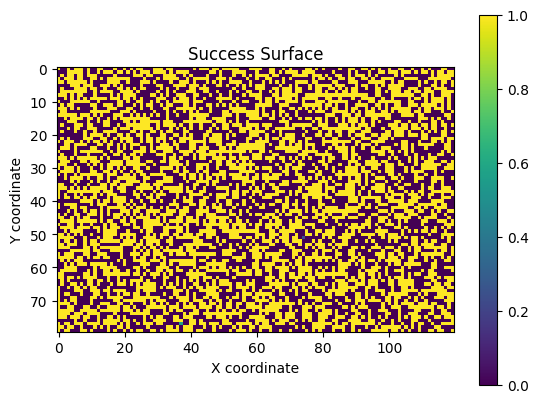

In [65]:
def generate_success_surface(policy_network, state):
    state_tensor = torch.FloatTensor(state).permute(2, 0, 1).unsqueeze(0)
    with torch.no_grad():
        success_probabilities = policy_network(state_tensor).squeeze().numpy()
    return success_probabilities

def visualize_success_surface(success_surface):
    plt.imshow(success_surface, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Success Surface')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

state = env.reset()
success_surface = generate_success_surface(policy_network, state)
visualize_success_surface(success_surface)

In [60]:
state

array([[[  0.70564175, 126.49110641,   0.99820126, ...,   1.        ,
           1.        ,   1.        ],
        [  0.699662  , 125.54282138,   0.99817707, ...,   0.        ,
           0.        ,   0.        ],
        [  1.57515826, 124.59534502,   0.99815244, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [116.49684432,  40.11234224,   0.99988653, ...,   0.        ,
           0.        ,   0.        ],
        [117.49683542,  40.04996879,   0.99994925, ...,   0.        ,
           0.        ,   0.        ],
        [118.49682667,  40.01249805,   0.99998726, ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.71455476, 126.17844507,   0.9981834 , ...,   0.        ,
           0.        ,   0.        ],
        [  0.70865023, 125.22779244,   0.99815869, ...,   0.        ,
           0.        ,   0.        ],
        [  1.57917123, 124.27791437,   0.99813353, ...,   0.        ,
           0.        ,   0.        ],
        ...,
